<img src="http://imgnews.naver.com/image/5239/2014/10/10/192108_image_1_99_20141010162402.jpg">

This kernel is prepared to analyze birth rates in US for 1994-2014 and make predictions based on the given data. It consists of the following parts:<font color='blue'>


    
* Introduction

* Loading Data

* Data exploration

* Feature engineering

* Model (LSTM)

* Prediction

* Summary
</font>




## Introduction

Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations.
Today we will consider US birth rates from the beginning of 1994 to the end of 2014. We will develope a model with LSTM to forecast birth rates in US for next years.

Two datasets have been combined to have wider range of dates. The data consists od the following columns:
year (1994-2014), month (1-12), date_of_month (1-31), day_of_week (1-7), and births (# of births).
After analyzing data we will create new column which will help us work with time series. Later we will develop a model (LSTM-Long Short Term Memory) to make predictions based on the given data.

## Loading data

We will combine two datasets to have wider range of dates.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
print(os.listdir("../input"))


['README.md', 'US_births_1994-2003_CDC_NCHS.csv', 'US_births_2000-2014_SSA.csv']


In [2]:
file_1994_2003=pd.read_csv('../input/US_births_1994-2003_CDC_NCHS.csv')
file_2000_2014=pd.read_csv('../input/US_births_2000-2014_SSA.csv')
file1=file_1994_2003.copy()
file2=file_2000_2014.copy()

file1=file1[file1["year"]<2000]
file2=file2[file2["year"]>=2000]
file=pd.concat([file1, file2], axis=0)

## Data exploration

The top rows of the combined data is as follows:

In [3]:
file.head(9)

,year,month,date_of_month,day_of_week,births
0,1994,1,1,6,8096
1,1994,1,2,7,7772
2,1994,1,3,1,10142
3,1994,1,4,2,11248
4,1994,1,5,3,11053
5,1994,1,6,4,11406
6,1994,1,7,5,11251
7,1994,1,8,6,8653
8,1994,1,9,7,7910


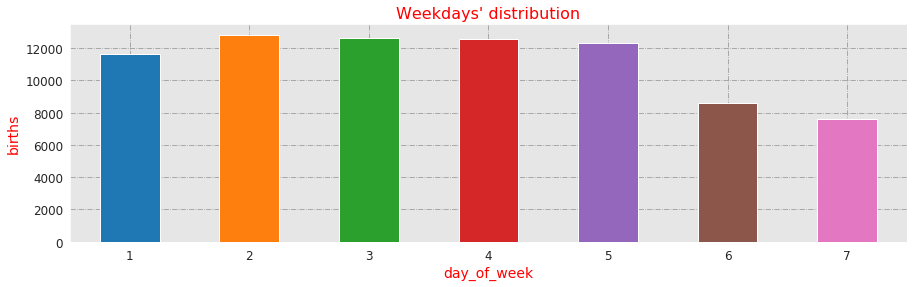

In [4]:
plt.figure(figsize=(15,4))
sns.set_style("darkgrid", {"axes.facecolor": "0.9", 'grid.color': '.6', 'grid.linestyle': '-.'})
dist1=file.groupby("day_of_week")["births"].mean()
dist1.plot(kind='bar', rot=0)
plt.xlabel("day_of_week", fontsize=14, color="r")
plt.ylabel("births", fontsize=14, color="r")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Weekdays' distribution", fontsize=16, color="r")
plt.show()

One can notice that the number of births on weekends is less than that on weekdays.

The main statistics is as follows:

In [5]:
file.describe()

,year,month,date_of_month,day_of_week,births
count,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000
mean,2004.000000,6.523077,15.729205,3.999870,11175.063625
std,6.055444,3.448888,8.800483,2.000359,2183.379461
min,1994.000000,1.000000,1.000000,1.000000,5728.000000
25%,1999.000000,4.000000,8.000000,2.000000,8786.250000
50%,2004.000000,7.000000,16.000000,4.000000,11981.000000
75%,2009.000000,10.000000,23.000000,6.000000,12816.000000
max,2014.000000,12.000000,31.000000,7.000000,16081.000000


In [6]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7670 entries, 0 to 5478
Data columns (total 5 columns):
year             7670 non-null int64
month            7670 non-null int64
date_of_month    7670 non-null int64
day_of_week      7670 non-null int64
births           7670 non-null int64
dtypes: int64(5)
memory usage: 359.5 KB


From above we can notice that there are no outliers, and all the numbers are integers.

Below we can see the total number of births in US from 1994 to 2014, inclusive.

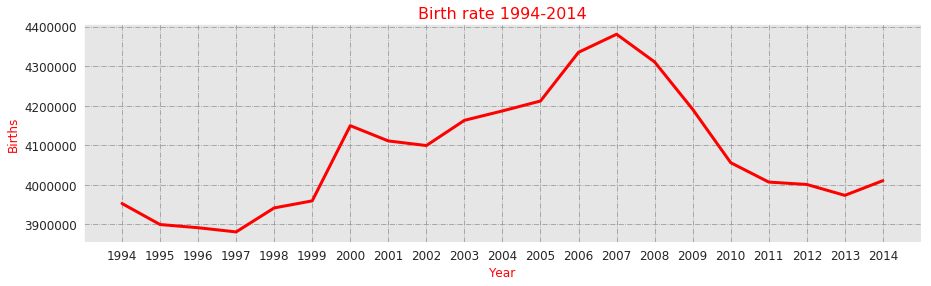

In [7]:
plt.figure(figsize=(15,4))
year_sum=file.groupby("year")[['births']].sum()
plt.plot(year_sum, linewidth=3, color="r")
plt.xlabel("Year", fontsize=12, color="r")
plt.ylabel("Births", fontsize=12, color="r")
plt.xticks(range(1994,2015,1), fontsize=12); plt.yticks(fontsize=12)
plt.title("Birth rate 1994-2014", fontsize=16, color="r")
plt.show()

Next we can see the range of the births within each year through the mentioned period.

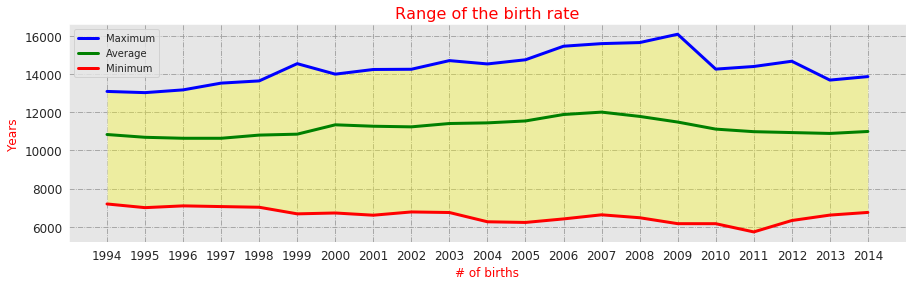

In [8]:
plt.figure(figsize=(15,4))
year_min=file.groupby("year")[['births']].min(); year_max=file.groupby("year")[['births']].max(); year_mean=file.groupby("year")[['births']].mean()
x=year_mean.index
plt.plot(year_max, linewidth=3, label="Maximum", color="b")
plt.plot(year_mean, linewidth=3, label="Average", color="g")
plt.plot(year_min, linewidth=3, label="Minimum", color="r")
plt.fill_between(x,year_min["births"], year_max["births"], alpha=0.3, facecolor='yellow')
plt.xticks(range(1994,2015,1), fontsize=12); plt.yticks(fontsize=12)
plt.xlabel("# of births", fontsize=12, color="r"); plt.ylabel("Years", fontsize=12, color="r")
plt.title("Range of the birth rate", fontsize=16, color="r")
plt.legend(loc='best')
plt.draw()

## Feature engineering

Here we'll start adding a column combining day, month, year for indexing the time series. 

In [9]:
file['date'] = file["year"].map(str)+ "-" + file["month"].map(str)+ "-" + file["date_of_month"].map(str)
file.head()

,year,month,date_of_month,day_of_week,births,date
0,1994,1,1,6,8096,1994-1-1
1,1994,1,2,7,7772,1994-1-2
2,1994,1,3,1,10142,1994-1-3
3,1994,1,4,2,11248,1994-1-4
4,1994,1,5,3,11053,1994-1-5


In order to work with time series, we should have datetime for the index. So let's consider the number of births along with the time, and later put timeseries as indices of the data.

In [10]:
ts=file.copy()
ts=pd.DataFrame(ts, columns=['date', 'births'])
ts.tail()

,date,births
5474,2014-12-27,8656
5475,2014-12-28,7724
5476,2014-12-29,12811
5477,2014-12-30,13634
5478,2014-12-31,11990


In [11]:
ts['Date']=pd.to_datetime(ts['date'])
ts=ts.set_index(['Date'])
ts.drop("date", axis=1, inplace=True)
ts.head()

,births
Date,
1994-01-01,8096
1994-01-02,7772
1994-01-03,10142
1994-01-04,11248
1994-01-05,11053


An interesting trend can be seen in the next graph, where the average number of births increases from April to August-September. Then it sharply drops till the end of each year. Also there is slightly but consistant increase in the first month of each year.

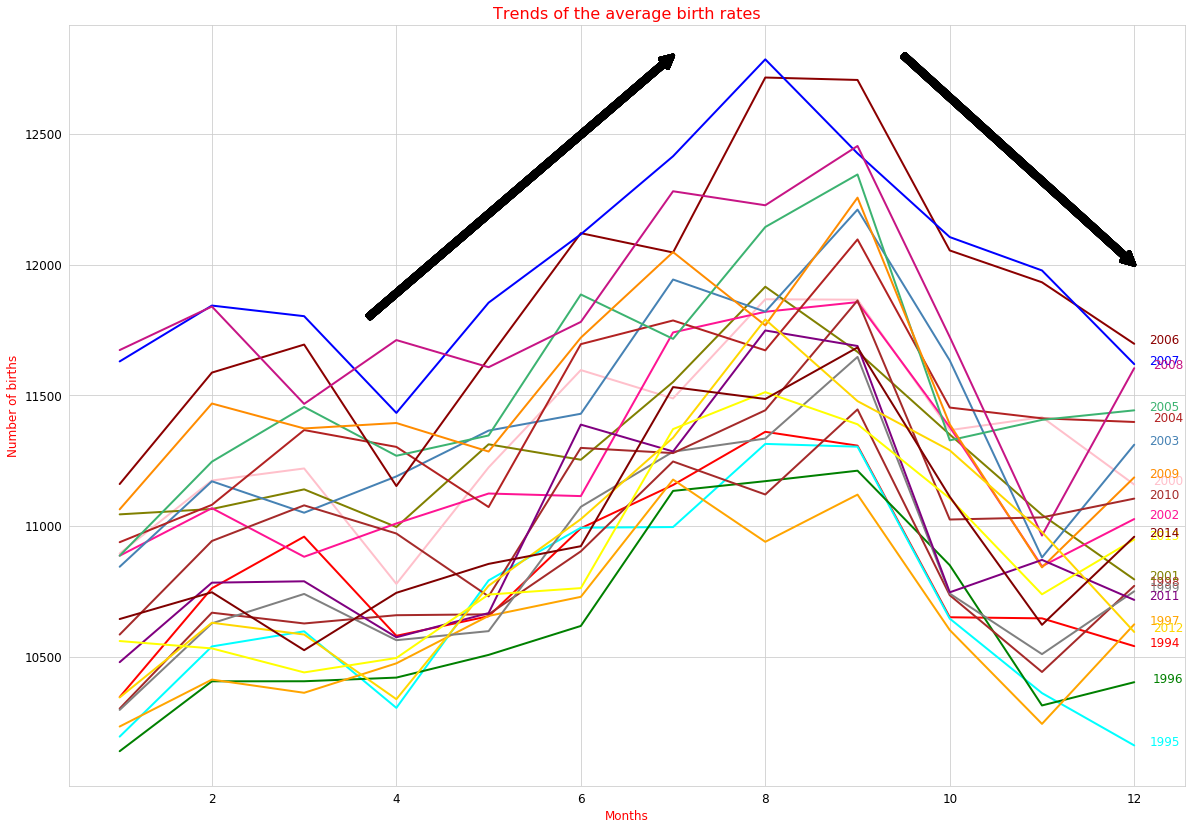

In [12]:
sns.set_style("whitegrid")
mycolors = ['red', 'cyan', 'green', 'orange', 'brown', \
            'grey', 'pink', 'olive', 'deeppink', 'steelblue', \
            'firebrick', 'mediumseagreen', 'darkred', 'blue', 'MediumVioletRed',\
            'darkorange', 'brown', 'purple', 'gold', 'yellow', 'maroon']
plt.figure(figsize=(20,14))
for i, c in enumerate(range(1994,2015)):
    file_c=file[file["year"]==c]
    file_c_grouped=file_c.groupby("month")[['births']].mean()
    x=file_c_grouped.index.tolist()
    y=file_cy=file_c_grouped['births']
    plt.plot(x,y, linewidth=2, label=c, color=mycolors[i])
    plt.text(file.loc[file.year==c, :].shape[0]/30, file_c_grouped[file_c_grouped.index==12]['births'].mean(), c, fontsize=12, color=mycolors[i])
    plt.yticks(fontsize=14, color="k")
    plt.xticks(fontsize=14, color="k")
    plt.xlabel("Months",fontsize=12, color="r")
    plt.ylabel("Number of births", fontsize=12, color="r")
    plt.annotate("", xy=(7, 12800), xytext=(3.7,11800), arrowprops=dict(ec="k", fc="k", lw=4))
    plt.annotate("", xy=(12,12000), xytext=(9.5, 12800), arrowprops=dict(ec="k", fc="k",  lw=4))
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Trends of the average birth rates", fontsize=16, color="r")
plt.draw()

## Model (LSTM)

Now it's the time to split our data into training and testing sets. We will train the model on the training set and leter check the performance on the test set.

Before doing that let's plot the time series. After that we can see that we should resample because there are too many points on daily bases. 

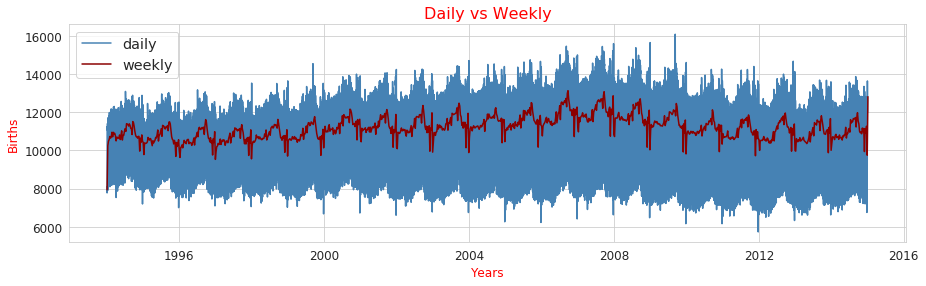

In [13]:
plt.figure(figsize=(15,4))
plt.plot(ts, label="daily", color="steelblue")
plt.plot(ts.resample("w").mean(), label="weekly", color="darkred")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Daily vs Weekly", fontsize=16, color="r")
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("Births", fontsize=12, color="r")
plt.legend(loc="best", fontsize = 'x-large')
plt.draw()

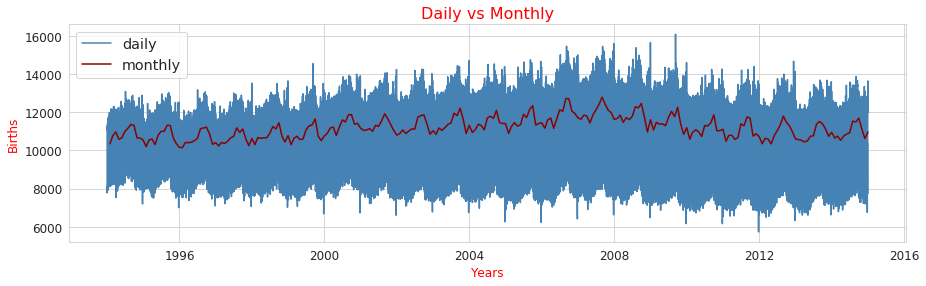

In [14]:
plt.figure(figsize=(15,4))
plt.plot(ts, label="daily", color="steelblue")
plt.plot(ts.resample("M").mean(), label="monthly", color="darkred")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Daily vs Monthly", fontsize=16, color="r")
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("Births", fontsize=12, color="r")
plt.legend(loc="best", fontsize = 'x-large')
plt.draw()

For developing a model, let's consider distribution as of the end date of each month.

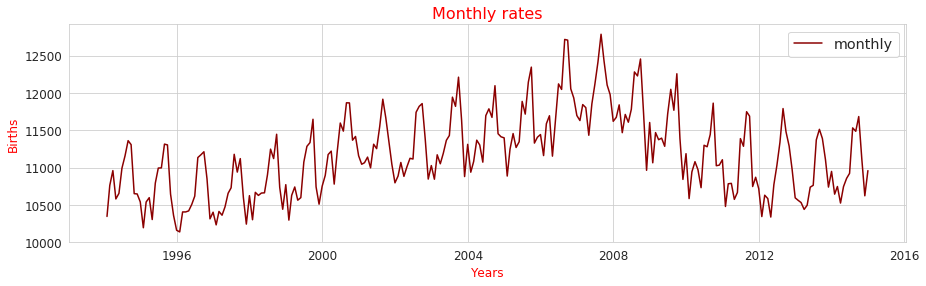

In [15]:
month_mean=ts.resample("M").mean()
plt.figure(figsize=(15,4))
plt.plot(month_mean, label="monthly", color="darkred")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Monthly rates", fontsize=16, color="r")
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("Births", fontsize=12, color="r")
plt.legend(loc="best", fontsize = 'x-large')
plt.draw()

In [16]:
print("The shape of the original data: ",ts.shape)
print("The shape of the sampled data: ", month_mean.shape)

The shape of the original data:  (7670, 1)
The shape of the sampled data:  (252, 1)


We will train our model on the first 200 points and test if for the rest 52.

In [17]:
train=month_mean[:200]
test=month_mean[200:]
print("The shape of training set: ", train.shape)
print("The shape of testing set: ", test.shape)

The shape of training set:  (200, 1)
The shape of testing set:  (52, 1)


In [18]:
print("The splitting timestamp is after ", train.index[-1])


The splitting timestamp is after  2010-08-31 00:00:00


Below we can see the time series plot split into two parts(Training set and Testing set).

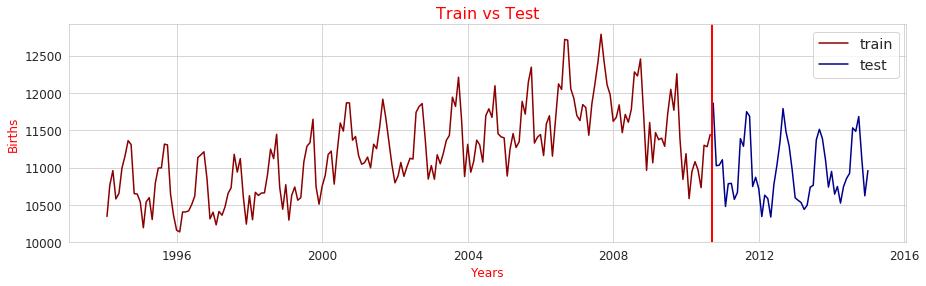

In [19]:
plt.figure(figsize=(15,4))
plt.plot(train, label="train", color="darkred")
plt.plot(test, label="test", color="darkblue")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Train vs Test", fontsize=16, color="r")
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("Births", fontsize=12, color="r")
plt.legend(loc="best", fontsize = 'x-large')
plt.axvline(pd.to_datetime('2010-09-15'), color='r', linestyle='-', linewidth=2)
plt.draw()

The data for our sequence prediction problem needs to be scaled. We can normalize our dataset using the scikit-learn object MinMaxScaler.

In [20]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In our case we will be using 60 as time step i.e. we will look into 2 months of data to predict next months' rates.

In [21]:
X_train = []
y_train = []
for i in range(60, 200):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate=0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
np.random.seed(0)
regressor.fit(X_train, y_train, epochs = 100, batch_size = 10, verbose=0)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [23]:
dataset_total = pd.concat((train['births'], test['births']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 112):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
prediction = regressor.predict(X_test)
prediction = sc.inverse_transform(prediction)
prediction = pd.DataFrame(prediction, index=test.index)

The top rows of the prediction for the testing time period is as follows:

In [24]:
prediction.head()

,0
Date,
2010-09-30,11380.013672
2010-10-31,10930.956055
2010-11-30,10623.726562
2010-12-31,10535.429688
2011-01-31,10613.466797


And here is the combined plot of the testing set, training set and predictions for the testing period.

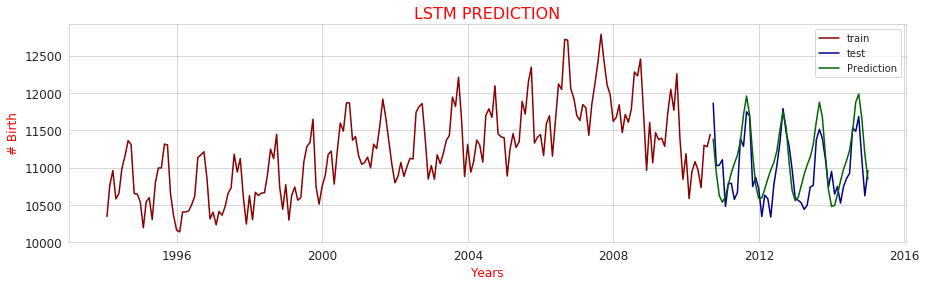

In [25]:
plt.figure(figsize=(15,4))
plt.plot(month_mean[:200], color = 'darkred', label = 'train')
plt.plot(month_mean[200:], color = 'darkblue', label = 'test')
plt.plot(prediction, color = 'darkgreen', label = 'Prediction')
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("LSTM PREDICTION", fontsize=16, color="r")
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("# Birth", fontsize=12, color="r")
plt.legend()
plt.show()

Not bad!

The predicted values are quite close to the values in test dataset. Let's zoom-in the right side of the graph to have closer look.

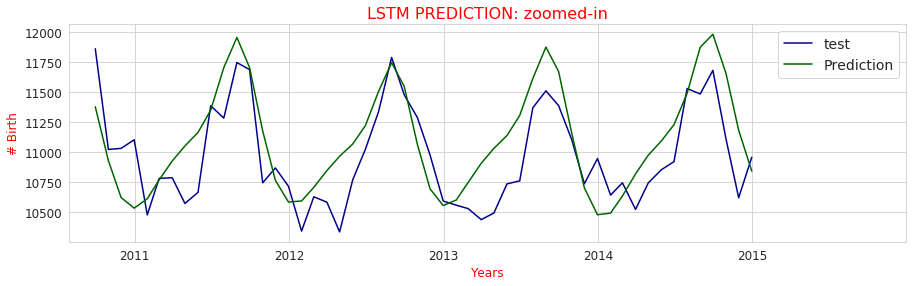

In [26]:
plt.figure(figsize=(15,4))
plt.plot(month_mean[200:], color = 'darkblue', label = 'test')
plt.plot(prediction, color = 'darkgreen', label = 'Prediction')
plt.title('LSTM PREDICTION: zoomed-in', fontsize=16, color="r")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("# Birth", fontsize=12, color="r")
plt.xlim('20100730', '20151231')
plt.legend(loc="best", fontsize=14)
plt.show()

To evaluate the performance, let's look at Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and evaluate the loss.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE is ", np.round(np.sqrt(mean_squared_error(test, prediction))))
print("MAE is ", np.round(mean_absolute_error(test, prediction)))
print("loss is ", np.round(regressor.evaluate(X_train ,y_train ,batch_size =10),4))

RMSE is  317.0
MAE is  263.0
140/140 [==============================] - 1s 6ms/step
loss is  0.0073


## Prediction

Being satisfied with the results, let's predict future values. To do so, we will use last 60 records to predict next one, and the newly predicted value will be included in the next timestamp, and so on. One of the drawbacks here is that if we want to predict for a longer period then more predicted values are considered for the new predictions. This will affect the accuracy of the prediction.

Let's predict the US birth rates for the next 36-month period.

In [28]:
def moving_test_window_preds(n_feature_preds):
    preds_moving=[]
    moving_test_window=[X_test[0,:].tolist()]
    moving_test_window=np.array(moving_test_window)
   
    for i in range(n_feature_preds):
        preds_one_step=regressor.predict(moving_test_window)
        preds_moving.append(preds_one_step[0,0])
        preds_one_step=preds_one_step.reshape(1,1,1)
        moving_test_window=np.concatenate((moving_test_window[:,1:,:],preds_one_step), axis= 1)
    preds_moving=np.array(preds_moving)
    preds_moving.reshape(1,-1)
    preds_moving=sc.inverse_transform(preds_moving.reshape(-1,1))
    return preds_moving

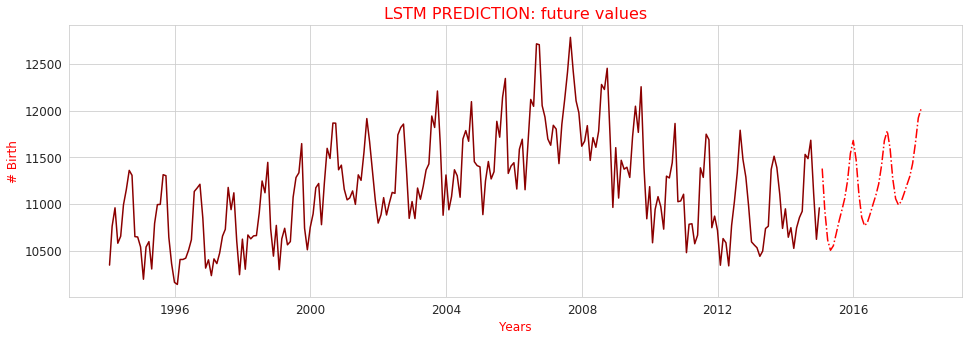

In [29]:
plt.figure(figsize=(16,5))
original=ts.resample("M").mean()
plt.plot(original, color = 'darkred', label = 'original')
future=pd.DataFrame(moving_test_window_preds(36), index=pd.date_range(start="20150101", end="20171231", freq="M"))
plt.plot(future, color="r", linestyle="-.")
plt.title('LSTM PREDICTION: future values', fontsize=16, color="r")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.xlabel("Years", fontsize=12, color="r"); plt.ylabel("# Birth", fontsize=12, color="r")
plt.draw()

## Summary

In this kernel we analyzed the data, having data visualization and feature engineering. As well as we developed LSTM model to predict future values of the birth is US.

Nice to see that the prediction rate has an increasing trend for future dates.

Hope you enjoyed the process. As always, your comments are appreciated.

I hope you liked this kernel and you will <font color="red">upvote :) </font>

Thanks!!!